## State of The Art Notes ##

* Referencia: https://core.ac.uk/download/pdf/78534675.pdf
* Referencia: https://ddd.uab.cat/pub/tfg/2016/169883/MartinezDomenechNerea-TFGAa2015-16.pdf
* Referencia: https://reader.elsevier.com/reader/sd/pii/S2046043022000119?token=3A6BF1409DB3AA4F51FA19FD5B78DA8EF45A35D24553686E6A341A4CB3E7486C9B12B833E7BE9F77396BB2D01F075D6B&originRegion=us-east-1&originCreation=20220924050124
* Referencia: https://www.faa.gov/sites/faa.gov/files/data_research/aviation_data_statistics/cost_delay_estimates.pdf

### Retrasos

* 93000 vuelos diarios
* 9000 aeropuertos
* 13000 aeronaves en aire
* 85% de puntualidad hasta media mañana, 70% en la tarde y 60% a la hora de la cena en temporada estival (climas cálidos y temperaturas altas)
* Según CODA (Central Office of Delay) en 2013 los vuelos acumularon de media 9.3 minutos de retrasos donde 30% de ellos se da por faltas de la aerolínea y el 45% por llegada de la aeronave, la tripulación o carga (Reactionary). En 2015 estos retrasos aumentaron a 10.2 minutos

### Términos de monetarios del retraso

* Un estudio del 2010 de la Administración Federal de Aviación determinó que los retrasos a la industria cuestan 8 billones USD. A los usuarios les cuesta 17 billones USD
* Según la Universidad de Westminster en 2004 cada minuto de retraso tiene un coste medio de 25 euros
* Las aerolíneas se sienten cómodas bajando su puntualidad (rango de 14 minutos de llegada tarde) a un 30% o 40% de las veces.
* En 2014 Airlines for America dice que el coste por retrasos de operaciones es de 81.18 USD por min

### Retrasos en Europa

* En Mayo del 2015 El Tiempo de Bloque Sobreimpulso (BTO) porcentaje de vuelos con un tiempo de bloque real que excede el tiempo de bloque programado fue del 31%
* El Indicador de Diferencia de Retraso en Vuelo (DDI -F), diferencia entra la salida y puntualidad de llegada expresada en minutos disminuyó en -2.9 minutos en Mayo del 2015 respecto del 2014
* Comisión Europea prevé que 19 aeropuertos europeos, estarán saturados afectando al 50% de los vuelos de pasarejos y carga para el 2030

### Identificación de las tareas críticas que ocasionan retrasos

* Desde Junio del 2003 todas las aerolíneas reportan las causas totales de retrasos y cancelaciones a la Oficina de Estadística y Transporte
* Para explicar el retraso se crearon las siguientes categorías:
  * Air Carrier: Se debe a tareas de la aerolínea (mantenimiento, limpieza del avión, carga de combustible, equipaje de carga, etc.)
  * Tiempo Extreme: Se debe a condiciones climatológicas (reales o previstas)
  * Sistema de Aviación Nacional (NAS): Se atribuyen al sistema de aviación nacional en una gama amplia de condiciones
  * Retrasos de vuelos: Un vuelo anterior con el mismo avión que llegó tarde.
  * Seguridad: Puede deberse a evacuación de una terminal, re-acceso a la aeronave debido a una falla de seguridad, equipos de control averiados, etc.
* Las categorías que más causan retrasos al 2015 son:
  1. Retrasos en Vuelo
  2. Air Carrier
  3. NAS
* Una característica que no está excenta de generar retrasos es el Turnaround o escalado de aeronaves el cual consiste en una serie de actividades que se realizan desde que se ha estacionado la aeronave hasta que el espacio físico queda libre para otra aeronave
* Es de vital importancia la planificación en la programación de vuelos que se realizan en conjunto entre las compañías aéreas y el aeropuerto ya que si por las razones que sean un vuelo no puede cumplir su operación programada, este atraso puede inmiscuir en los vuelos subsiguientes. El tiempo de programación comprende los siguientes tiempos:
  * T1 y T2: Tiempo en movimientos del avión en tierra en el aeropuerto de origen
  * T3 y T4: Tiempo en movimientos del avión en tierra en el aeropuerto de destino
  * T2 y T3: Tiempo en fase de vuelo


In [3]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, boxcox, chi2_contingency
from sklearn import preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

def shapiro_normality_test(data, fields):
  valid_fields = True
  for field in fields:
      if data[field].dtype != "object":
        continue
      else:
        valid_fields = False
        break
  if valid_fields:
    normal_test = ["ASYMETRIC" if shapiro(data[field])[1] < 0.05 else "NORMAL" for field in fields]
    symmetric_coef = [data[field].skew() for field in fields]
    df_normal = pd.DataFrame({
      "field": fields,
      "normality": normal_test,
      "symmetric_coef": symmetric_coef
    })
    return df_normal
  else:  
    raise Exception("Some fields are objects. Please change it, and test it again")

def box_cox_transformation(data, fields):
  valid_fields = True
  for field in fields:
      if data[field].dtype != "object":
        continue
      else:
        valid_fields = False
        break
  if valid_fields:
    df_transformed = pd.DataFrame()
    for field in fields:
      data[field] = data[field].apply(lambda x: 0.00001 if x == 0 else x)
      df_transformed[field] = boxcox(data[field])[0]
    return df_transformed
  else:  
    raise Exception("Some fields are objects. Please change it, and test it again")

def relation_between_variables_categorical_and_continuous(data=None, categorical=[], continuous=[], target=None):
  if len(categorical) == 0 and len(continuous) == 0 or target == None:
    raise Exception("Some paremeters are needed")
  else:
    if len(categorical) != 0 and len(continuous) != 0:
      if len(continuous) != 0:
        df_relations = pd.DataFrame(data[continuous].corrwith(data[target], method="spearman")).reset_index().rename(columns={"index":"fields", 0:"corrOrPvalue"})
        df_relations["DTYPE"] = "CONTINUOUS"
        df_relations["IsRelationed"] = df_relations["corrOrPvalue"].apply(lambda x: True if x > 0.5 else False)
      if len(categorical) != 0:
        relations = [chi2_contingency(pd.crosstab(index=data[field], columns=data[target], margins=True))[1] for field in categorical]
        df_temp = pd.DataFrame({
          "fields": categorical,
          "corrOrPvalue": relations
        })
        df_temp["DTYPE"] = "CATEGORICAL"
        df_temp["IsRelationed"] = df_temp["corrOrPvalue"].apply(lambda x: True if x < 0.05 else False)
    df_relations = pd.concat([df_relations, df_temp], axis=0)
  return df_relations

### Fast Data Exploration and Cleansing

In [4]:
df = pd.read_csv("data/dataset_SCL.csv")
df_distances = pd.read_csv("data/airports-distances.csv", index_col=[0])
df_airports = pd.read_csv("data/airports.csv", index_col=[0])

C:\Users\57310\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Structure Information
structure_information = pd.DataFrame({
    "datatypes":pd.value_counts(df.dtypes).keys().tolist(),
    "frequency":pd.value_counts(df.dtypes).values.tolist(),
    "columns":[df.select_dtypes(include=key).columns.tolist() for key in pd.value_counts(df.dtypes).keys()]
})
structure_information["datatypes"] = structure_information["datatypes"].astype(str)
structure_information

,datatypes,frequency,columns
0,object,15,"[Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES]"
1,int64,3,"[DIA, MES, AÑO]"


In [4]:
# Structure Information
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

### Data Transformation

* Se busca mantener nombres más entendibles para el análisis manteniedo en las variables de operación más no las de programación.
* Se hacen los cálculos necesarios y requerimientos del ejercicio en el punto 2. (TEMPORADA_ALTA, DIF_MIN, ATRASO_15, PERIODO_DIA)
* Se crean variables que pueden verse en la literatura común y que pueden significar mejoras en, el modelo o el entendimiento de los retrasos en un marco temporal. (DIA_SEMANA, DEP_TIME)
* Se importan datos exógenos que pueden significar mejoras en, el modelo o el entendimiento de los retrasos en un marco temporal. (TIEMPO_ESTIMADO_MINUTOS, DISTANCIA, PAIS)
* Se numeriza la variable CARRIER para que los modelos y pruebas a realizar no generen problema
* Se elminan las variables programadas, estas variables no aportan información importante para el entendimiento o modelado. DIF_MIN es la única variable que siendo de programación aporta valor. También se eliminan algunas variables de cruce que no aportan al modelo y que podrían correlacionarse con otras variables más informativas
* Se guarda el archivo con los campos requeridos en el ejercicio

In [5]:
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"], format="%Y-%m-%d")
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"], format="%Y-%m-%d")

df_t = df.rename(columns={
  "Emp-O": "CARRIER",
  "Vlo-O": "NUM_VUELO",
  "Ori-O": "ORIGEN_ID",
  "Des-O": "DESTINO_ID",
  "SIGLAORI": "ORIGEN_CIUDAD",
  "SIGLADES": "DESTINO_CIUDAD",
})

df_t["FECHA_VUELO"] = df["Fecha-O"].apply(lambda x: datetime.datetime.strftime(x, format="%Y-%m-%d"))
df_t["DIA_SEMANA"] = df["Fecha-O"].apply(lambda x: datetime.datetime.isoweekday(x))
df_t["DIF_MIN"] = df.apply(lambda x: int((x["Fecha-O"]-x["Fecha-I"]).seconds/60) if x["Fecha-O"] >= x["Fecha-I"] else 0, axis=1)
df_t["ATRASO_15"] = df_t["DIF_MIN"].apply(lambda x: 1 if x > 15 else 0)
df_t["DEP_TIME"] = df["Fecha-O"].apply(lambda x: int(str(x.hour)+str(x.minute)))
df_t["TEMPORADA_ALTA"] = df["Fecha-I"].apply(lambda x: 1 if x > datetime.datetime(2016, 12, 14) and x < datetime.datetime(2017, 3, 4) 
                                or x > datetime.datetime(2017, 7, 14) and x < datetime.datetime(2017, 8, 1) 
                                or x > datetime.datetime(2017, 9, 10) and x < datetime.datetime(2017, 10, 1)
                                or x > datetime.datetime(2017, 12, 14) and x < datetime.datetime(2018, 3, 4) else 0)
df_t["PERIODO_DIA"] = df_t["DEP_TIME"].apply(lambda x: "mañana" if x >= 50 and x <= 1159 
                                          else( "tarde" if x >= 1200 and x <= 1859 
                                          else("noche")))
df_t["PERIODO_DIA_NUMERO"] = df_t["DEP_TIME"].apply(lambda x: 0 if x >= 50 and x <= 1159 
                                          else( 1 if x >= 1200 and x <= 1859 
                                          else(2)))                                        
df_t = pd.merge(df_t, df_distances, left_on="DESTINO_ID", right_on="DESTINO_ID", how="inner").drop_duplicates()
df_t = pd.merge(df_t, df_airports,  left_on="DESTINO_ID", right_on="icao", how="inner").drop_duplicates().rename(columns={"countryId":"PAIS"})

df_t["TIEMPO_ESTIMADO_MINUTOS"] = df_t["TIEMPO_ESTIMADO"].apply(lambda x: datetime.timedelta(hours=int(x.split(":")[0]), minutes=int(x.split(":")[1]), seconds=int(x.split(":")[2])).seconds/60)
df_t["TIPO_VUELO_NUMERO"] = df_t["TIPOVUELO"].apply(lambda x: 1 if x == "I" else 0)

le = preprocessing.LabelEncoder()
le.fit(df_t["CARRIER"])
df_t["CARRIER_NUMERO"] = le.transform(df_t["CARRIER"])


df_t[["TEMPORADA_ALTA","DIF_MIN","ATRASO_15","PERIODO_DIA"]].to_csv("synthetic_features.csv")                    
df_t.drop(["Fecha-I", "Fecha-O", "Vlo-I", "Ori-I", "Des-I", "Emp-I","TIEMPO_ESTIMADO","DIANOM","OPERA","FECHA_VUELO","PERIODO_DIA", "TIPOVUELO", "id", "name", "iata", "icao", "city", "lat", "lon", "alt", "size", "timezone", "country", "AÑO"], axis=1, inplace=True)

In [76]:
# Structure Information
structure_information = pd.DataFrame({
    "datatypes":pd.value_counts(df_t.dtypes).keys().tolist(),
    "frequency":pd.value_counts(df_t.dtypes).values.tolist(),
    "columns":[df_t.select_dtypes(include=key).columns.tolist() for key in pd.value_counts(df_t.dtypes).keys()]
})
structure_information["datatypes"] = structure_information["datatypes"].astype(str)
structure_information

,datatypes,frequency,columns
0,int64,10,"[DIA, MES, DIA_SEMANA, DIF_MIN, ATRASO_15, DEP_TIME, TEMPORADA_ALTA, PERIODO_DIA_NUMERO, PAIS, TIPO_VUELO_NUMERO]"
1,object,6,"[NUM_VUELO, ORIGEN_ID, DESTINO_ID, CARRIER, ORIGEN_CIUDAD, DESTINO_CIUDAD]"
2,float64,2,"[DISTANCIA, TIEMPO_ESTIMADO_MINUTOS]"
3,int32,1,[CARRIER_NUMERO]


### Primeras Conclusiones

* Los diagramas de dispersión e histogramas son una buena fuente de análisis descriptivo. Para el caso de los retrasos como primeras conclusiones se puede evidenciar que Enero, Marzo, Julio y Diciembre son meses que presentan picos de retrasos, y una tendencia desde principio de año hasta fin de año se evidencia en 2017. Esto coincide con las fechas de temporada donde la tendencia en Marzo y Septiembre parece ir acumulando retrasos para finalmente alcanzar sus puntos máximos en Julio y Diciembre. Así mismo, el Viernes en temporada parece ser un día de retrasos aunque el comportamiento que se puede distinguir de esta primer técnica es que los días Martes y Jueves por lo general cuentan con retrasos. Así mismo, los horarios en la noche y la madrugada del siguiente día son horarios con retrasos frecuentes que se ven disminuidos en la mañana, es válido también acotar que la mañana no sólo cuenta con el mejor cumplimiento sino que la duración media de los retrasos disminuye en 4 minutos respecto del horario con más retrasos, este comportamiento finalmente coincidente con el estado del arte; Los retrasos en la mañana son del 16%, en la tarde del 20% y la noche del 22%, También es válido decir que la cantidad de vuelos disminuye a medida que pasa el día por lo que el impacto del retraso puede tener mayor relevancia en la tarde y noche que en la mañana. Por otro lado, los vuelos internacionales son aquellos que más retrasos tienen, sin embargo, son vuelos internacionales a distancias cortas, los retrasos pueden tener muchas razones según los estudiado en el estado del arte y no se cuenta con los datos apropiados para tipificar la razón del retraso. Sin embargo, dentro de las múltiples opciones de retraso se encuentran que, son vuelos de escala que llegaron tarde previamente a Santiago y deben salir de Santiago a otros destinos, son vuelos que se atrasan por las condiciones climatológicas del destino, el tráfico aéreo en los aeropuertos destino es alto, etc. Sin duda alguna, los retrasos en vuelos de temporada alta contienen una mayor proporción de retrasos que en temporada baja, sin embargo, es curioso ver una disminución considerable de vuelos para temporada alta como sucede con los diferentes periodos del día.

* Finalmente en un marco general, existe un cumplimiento mayor en vuelos que los incumplimientos, el 80% de los vuelos aproximadamente tuvieron un cumplimiento en sus horarios, sin embargo, algunos comportamientos críticos se vieron reflejados en el 2017 con algunas aerolíneas dentro de las cuales se encuentran TPU, 56R y PUE, vuelos operados según la base por Avianca, Latin American Wings y Plus Ultra Lineas Aéreas respectivamente. También es necesario decir que la cantidad de vuelos que éstas aerolíneas tuvieron en el año estuvieron 2017 estuvieron muy por debajo de la media. Es de destacar el comportamiento de aerolíneas como LAN (Latam Airlines), LXP (Grupo Latam) y SKU (SKY Airline) cuya cantidad de vuelos es altamente superior a la media de vuelos del 2017 y estuvieron por debajo del 20% en vuelos retrasados durante ese año. Respecto de los destinos, una de las gráficas confirma que la cantidad de vuelos nacionales es altamente superior a los vuelos internacionales pero que la mayor cantidad de retrasos se dan en vuelos internacionales. Australia y las Malvinas son destinos críticos, sin embargo, es de aclarar que la muestras no son significantes para concluir dado que la cantidad de vuelos que se realizan hacia esos destinos es también inferior a la media de vuelos. En general, la mayoría de aerolíneas se encuentran dentro del rango de puntualidad que el estado del arte menciona, aceptan, es decir, dentro del 30% al 40% de puntualidad. 

* El tiempo medio de retraso por aerolíneas y/o destino parecen no mostrar un patron relevante respecto de los retrasos. 

<Figure size 2880x720 with 0 Axes>

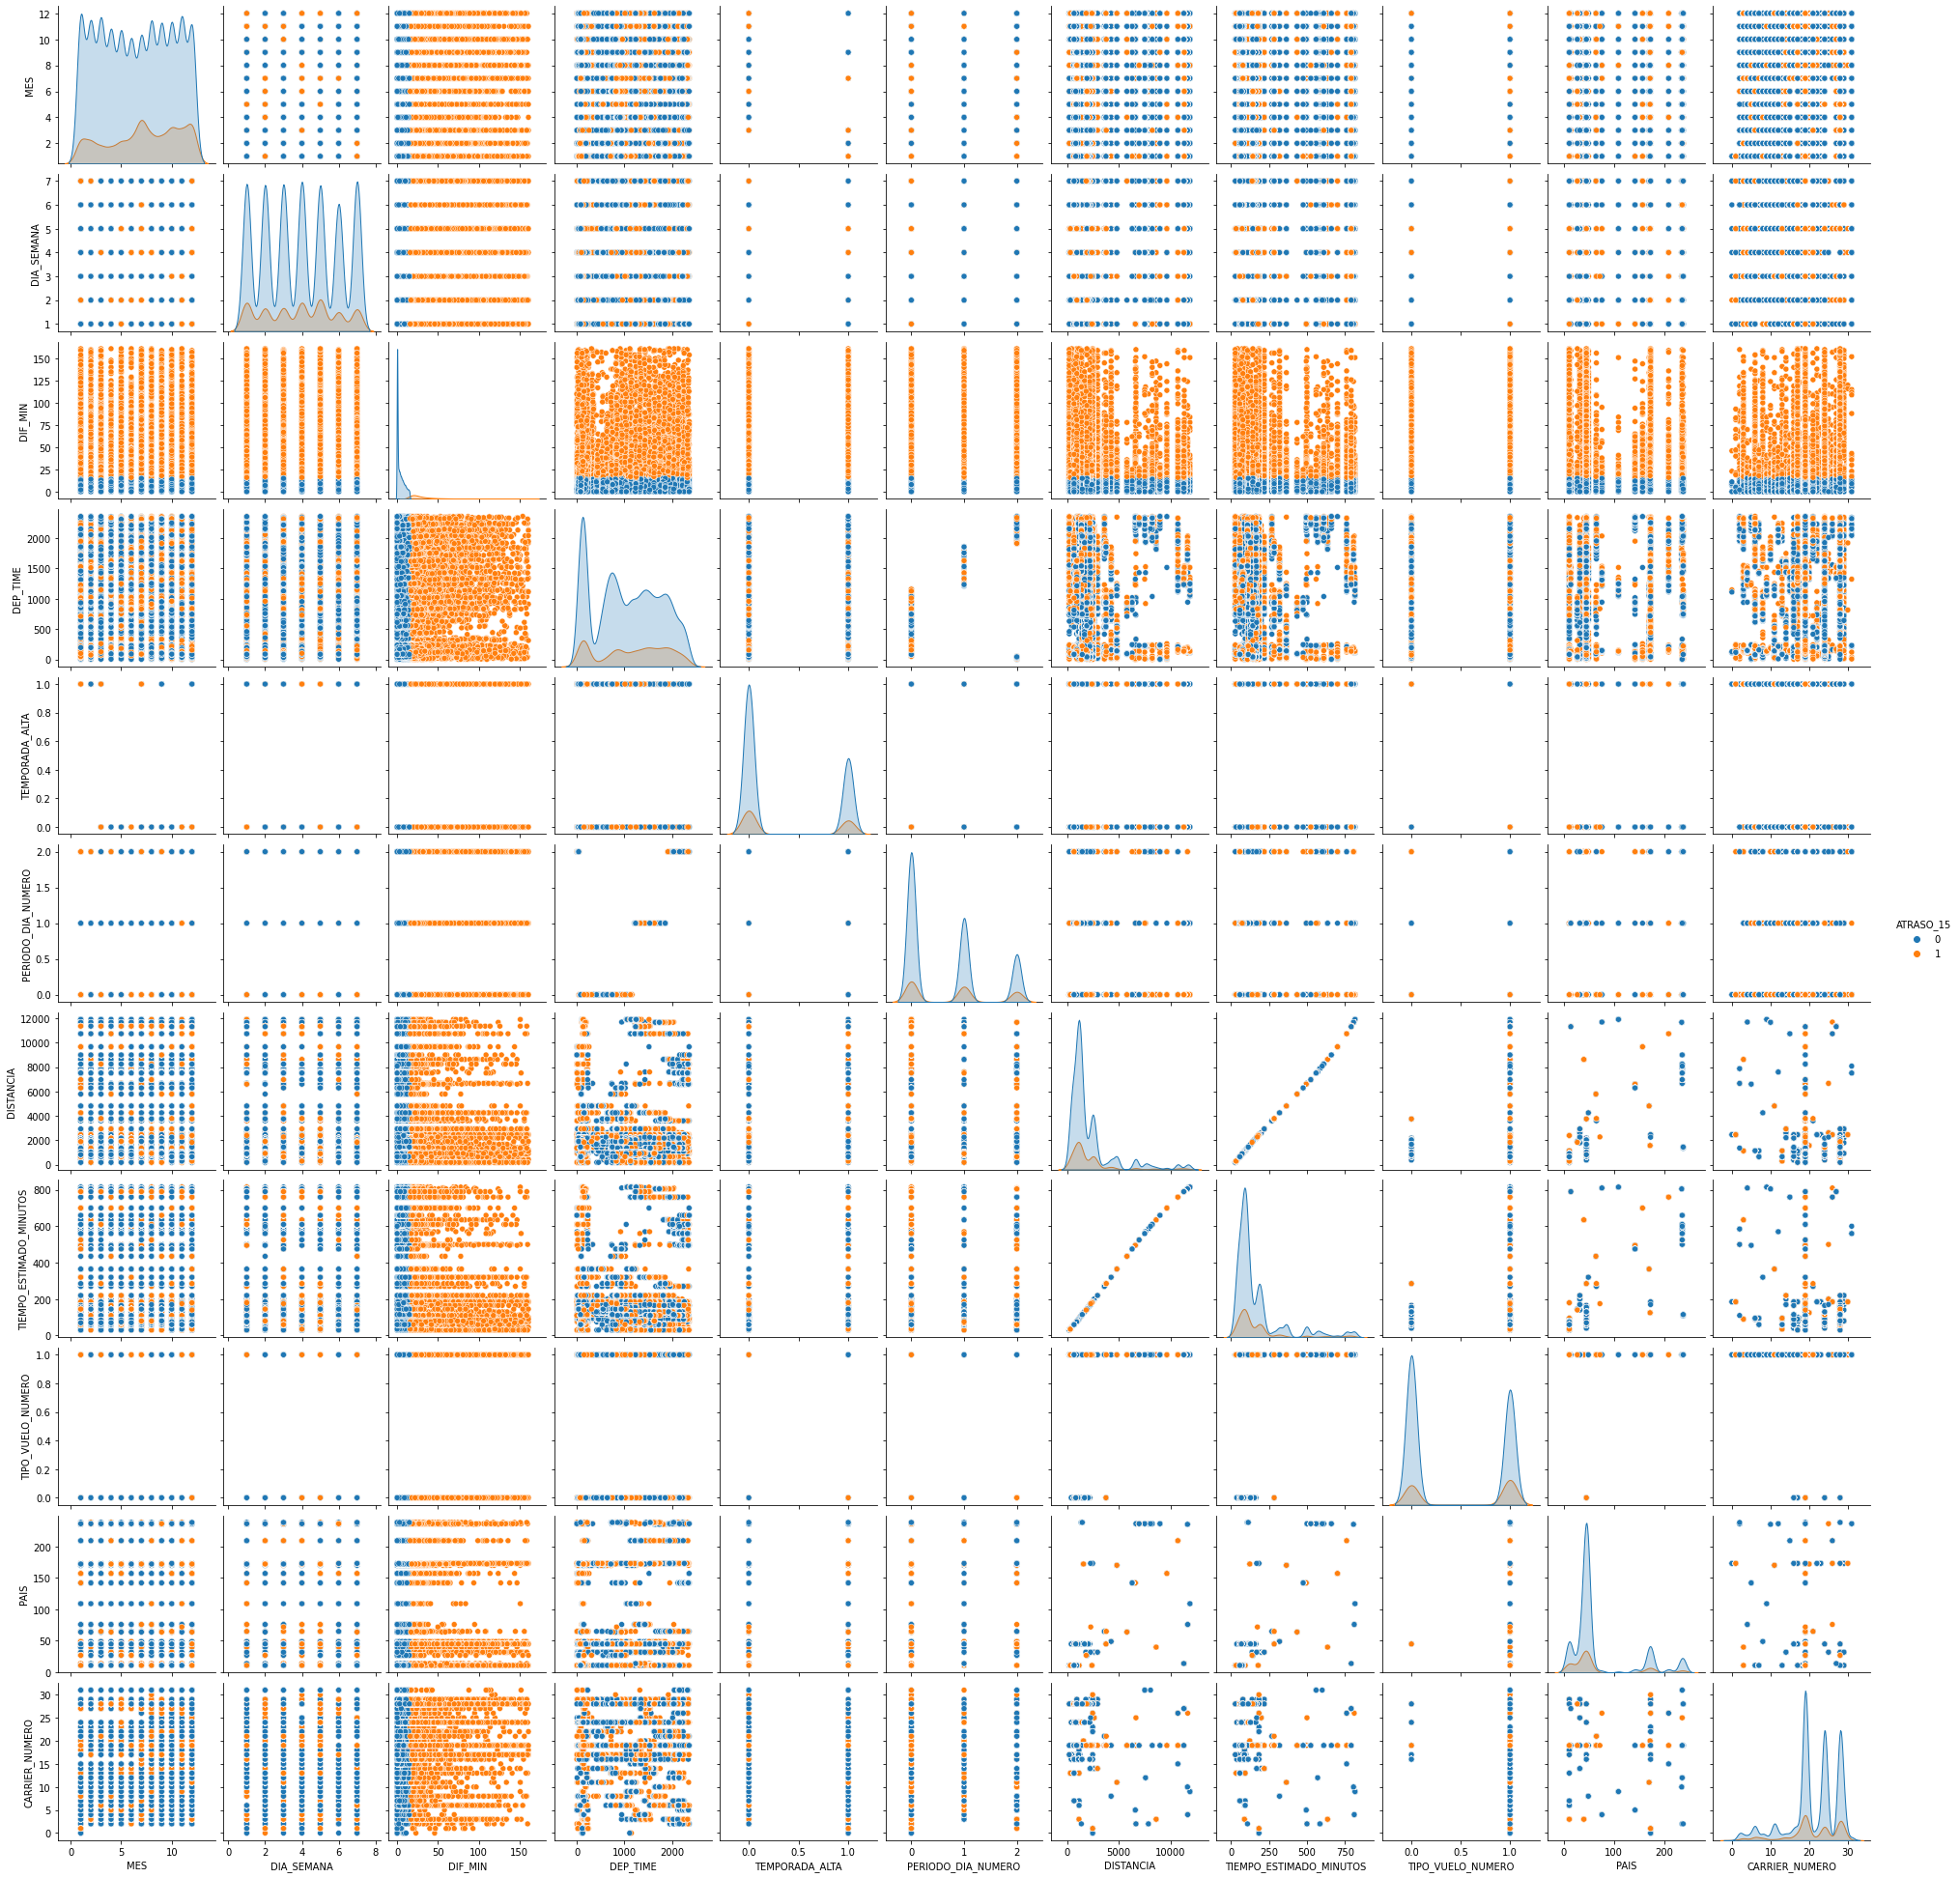

In [29]:
plt.figure(figsize=(40,10))
sns.pairplot(df_t[["MES","DIA_SEMANA","DIF_MIN","DEP_TIME","TEMPORADA_ALTA","PERIODO_DIA_NUMERO","DISTANCIA","TIEMPO_ESTIMADO_MINUTOS","TIPO_VUELO_NUMERO","PAIS", "CARRIER_NUMERO","ATRASO_15"]], hue="ATRASO_15")
plt.show()

<AxesSubplot:xlabel='ATRASO_15', ylabel='Count'>

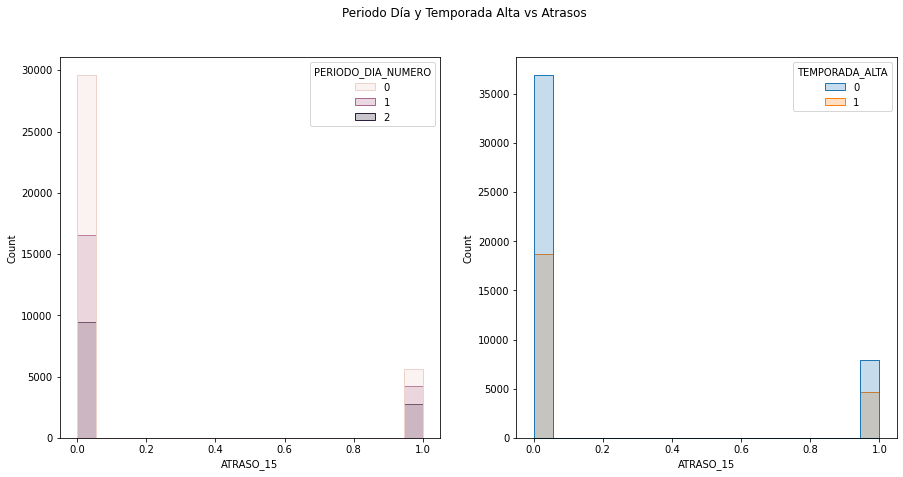

In [72]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
fig.suptitle('Periodo Día y Temporada Alta vs Atrasos')
sns.histplot(ax=axes[0], data=df_t, x="ATRASO_15", hue="PERIODO_DIA_NUMERO",  element="step")
sns.histplot(ax=axes[1], data=df_t, x="ATRASO_15", hue="TEMPORADA_ALTA",  element="step")

In [69]:
pd.DataFrame({
  "% Retraso de vuelos por Temporada (0-1)":[
    df_t[df_t["TEMPORADA_ALTA"].isin([1])]["ATRASO_15"].value_counts()[1]/df_t[df_t["TEMPORADA_ALTA"].isin([1])]["ATRASO_15"].value_counts().sum(),
    df_t[df_t["TEMPORADA_ALTA"].isin([0])]["ATRASO_15"].value_counts()[1]/df_t[df_t["TEMPORADA_ALTA"].isin([0])]["ATRASO_15"].value_counts().sum()
  ],
  "CANTIDAD_DE_VUELOS_TOTALES":[
    df_t[df_t["TEMPORADA_ALTA"].isin([1])]["ATRASO_15"].value_counts().sum(),
    df_t[df_t["TEMPORADA_ALTA"].isin([0])]["ATRASO_15"].value_counts().sum(),
  ],
  "MEDIA DE DURACIÓN EN MINUTOS":[
    df_t[df_t["TEMPORADA_ALTA"].isin([1])]["DIF_MIN"].mean(),
    df_t[df_t["TEMPORADA_ALTA"].isin([0])]["DIF_MIN"].mean(),
  ],
  "DESVIACIÓN ESTANDAR DE DURACIÓN EN MINUTOS":[
    df_t[df_t["TEMPORADA_ALTA"].isin([1])]["DIF_MIN"].mean(),
    df_t[df_t["TEMPORADA_ALTA"].isin([0])]["DIF_MIN"].mean(),
  ]
}, index=["alta", "baja"])

,% Retraso de vuelos por Temporada (0-1),CANTIDAD_DE_VUELOS_TOTALES,MEDIA DE DURACIÓN EN MINUTOS,DESVIACIÓN ESTANDAR DE DURACIÓN EN MINUTOS
alta,0.198999,23382,10.762723,10.762723
baja,0.177606,44824,9.778288,9.778288


In [70]:
pd.DataFrame({
  "% Retraso de vuelos por Periodo (0-1)":[
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([0])]["ATRASO_15"].value_counts()[1]/df_t[df_t["PERIODO_DIA_NUMERO"].isin([0])]["ATRASO_15"].value_counts().sum(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([1])]["ATRASO_15"].value_counts()[1]/df_t[df_t["PERIODO_DIA_NUMERO"].isin([1])]["ATRASO_15"].value_counts().sum(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([2])]["ATRASO_15"].value_counts()[1]/df_t[df_t["PERIODO_DIA_NUMERO"].isin([2])]["ATRASO_15"].value_counts().sum()
  ],
  "CANTIDAD_DE_VUELOS_TOTALES":[
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([0])]["ATRASO_15"].value_counts().sum(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([1])]["ATRASO_15"].value_counts().sum(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([2])]["ATRASO_15"].value_counts().sum()
  ],
  "MEDIA DE DURACIÓN EN MINUTOS":[
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([0])]["DIF_MIN"].mean(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([1])]["DIF_MIN"].mean(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([2])]["DIF_MIN"].mean()
  ],
  "DESVIACIÓN ESTANDAR DE DURACIÓN EN MINUTOS":[
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([0])]["DIF_MIN"].std(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([1])]["DIF_MIN"].std(),
    df_t[df_t["PERIODO_DIA_NUMERO"].isin([2])]["DIF_MIN"].std()
  ]
}, index=["mañana", "tarde", "noche"])

,% Retraso de vuelos por Periodo (0-1),CANTIDAD_DE_VUELOS_TOTALES,MEDIA DE DURACIÓN EN MINUTOS,DESVIACIÓN ESTANDAR DE DURACIÓN EN MINUTOS
mañana,0.160153,35210,8.996052,17.523397
tarde,0.202029,20794,10.711840,18.479346
noche,0.227340,12202,12.331011,21.587007


### Composición de los Datos

* Finalmente las variables que más se espera que influyan en la predicción se encuentran relacionadas con el factor tiempo agrupado. Es decir, MES y TEMPORADA_ALTA. Estas dos variables se confirman dada que en en temporada se observa como la cantidad de vuelos en temporada alta se reducen, como se había concluido anteriormente en la sección de Primeras Conclusiones pero la tasa de retrasos se encuentra por encima de la tasa de cumplimiento. Cómo se comentó anteriormente esto agranda el impacto en las aerolíneas y usuarios en estas etapas del año. La gráfica mensual se observa una ligera tendencia creciente desde Enero hasta Diciembre con picos en los meses de temporada alta. Se espera también que la variable TIPO_VUELO sea importante para el pronóstico ya que se ha podido observar que los vuelos internacionales pese a que no representan la misma cantidad de vuelos nacionales producen más retrasos que también se comentaron en las primeras conclusiones.

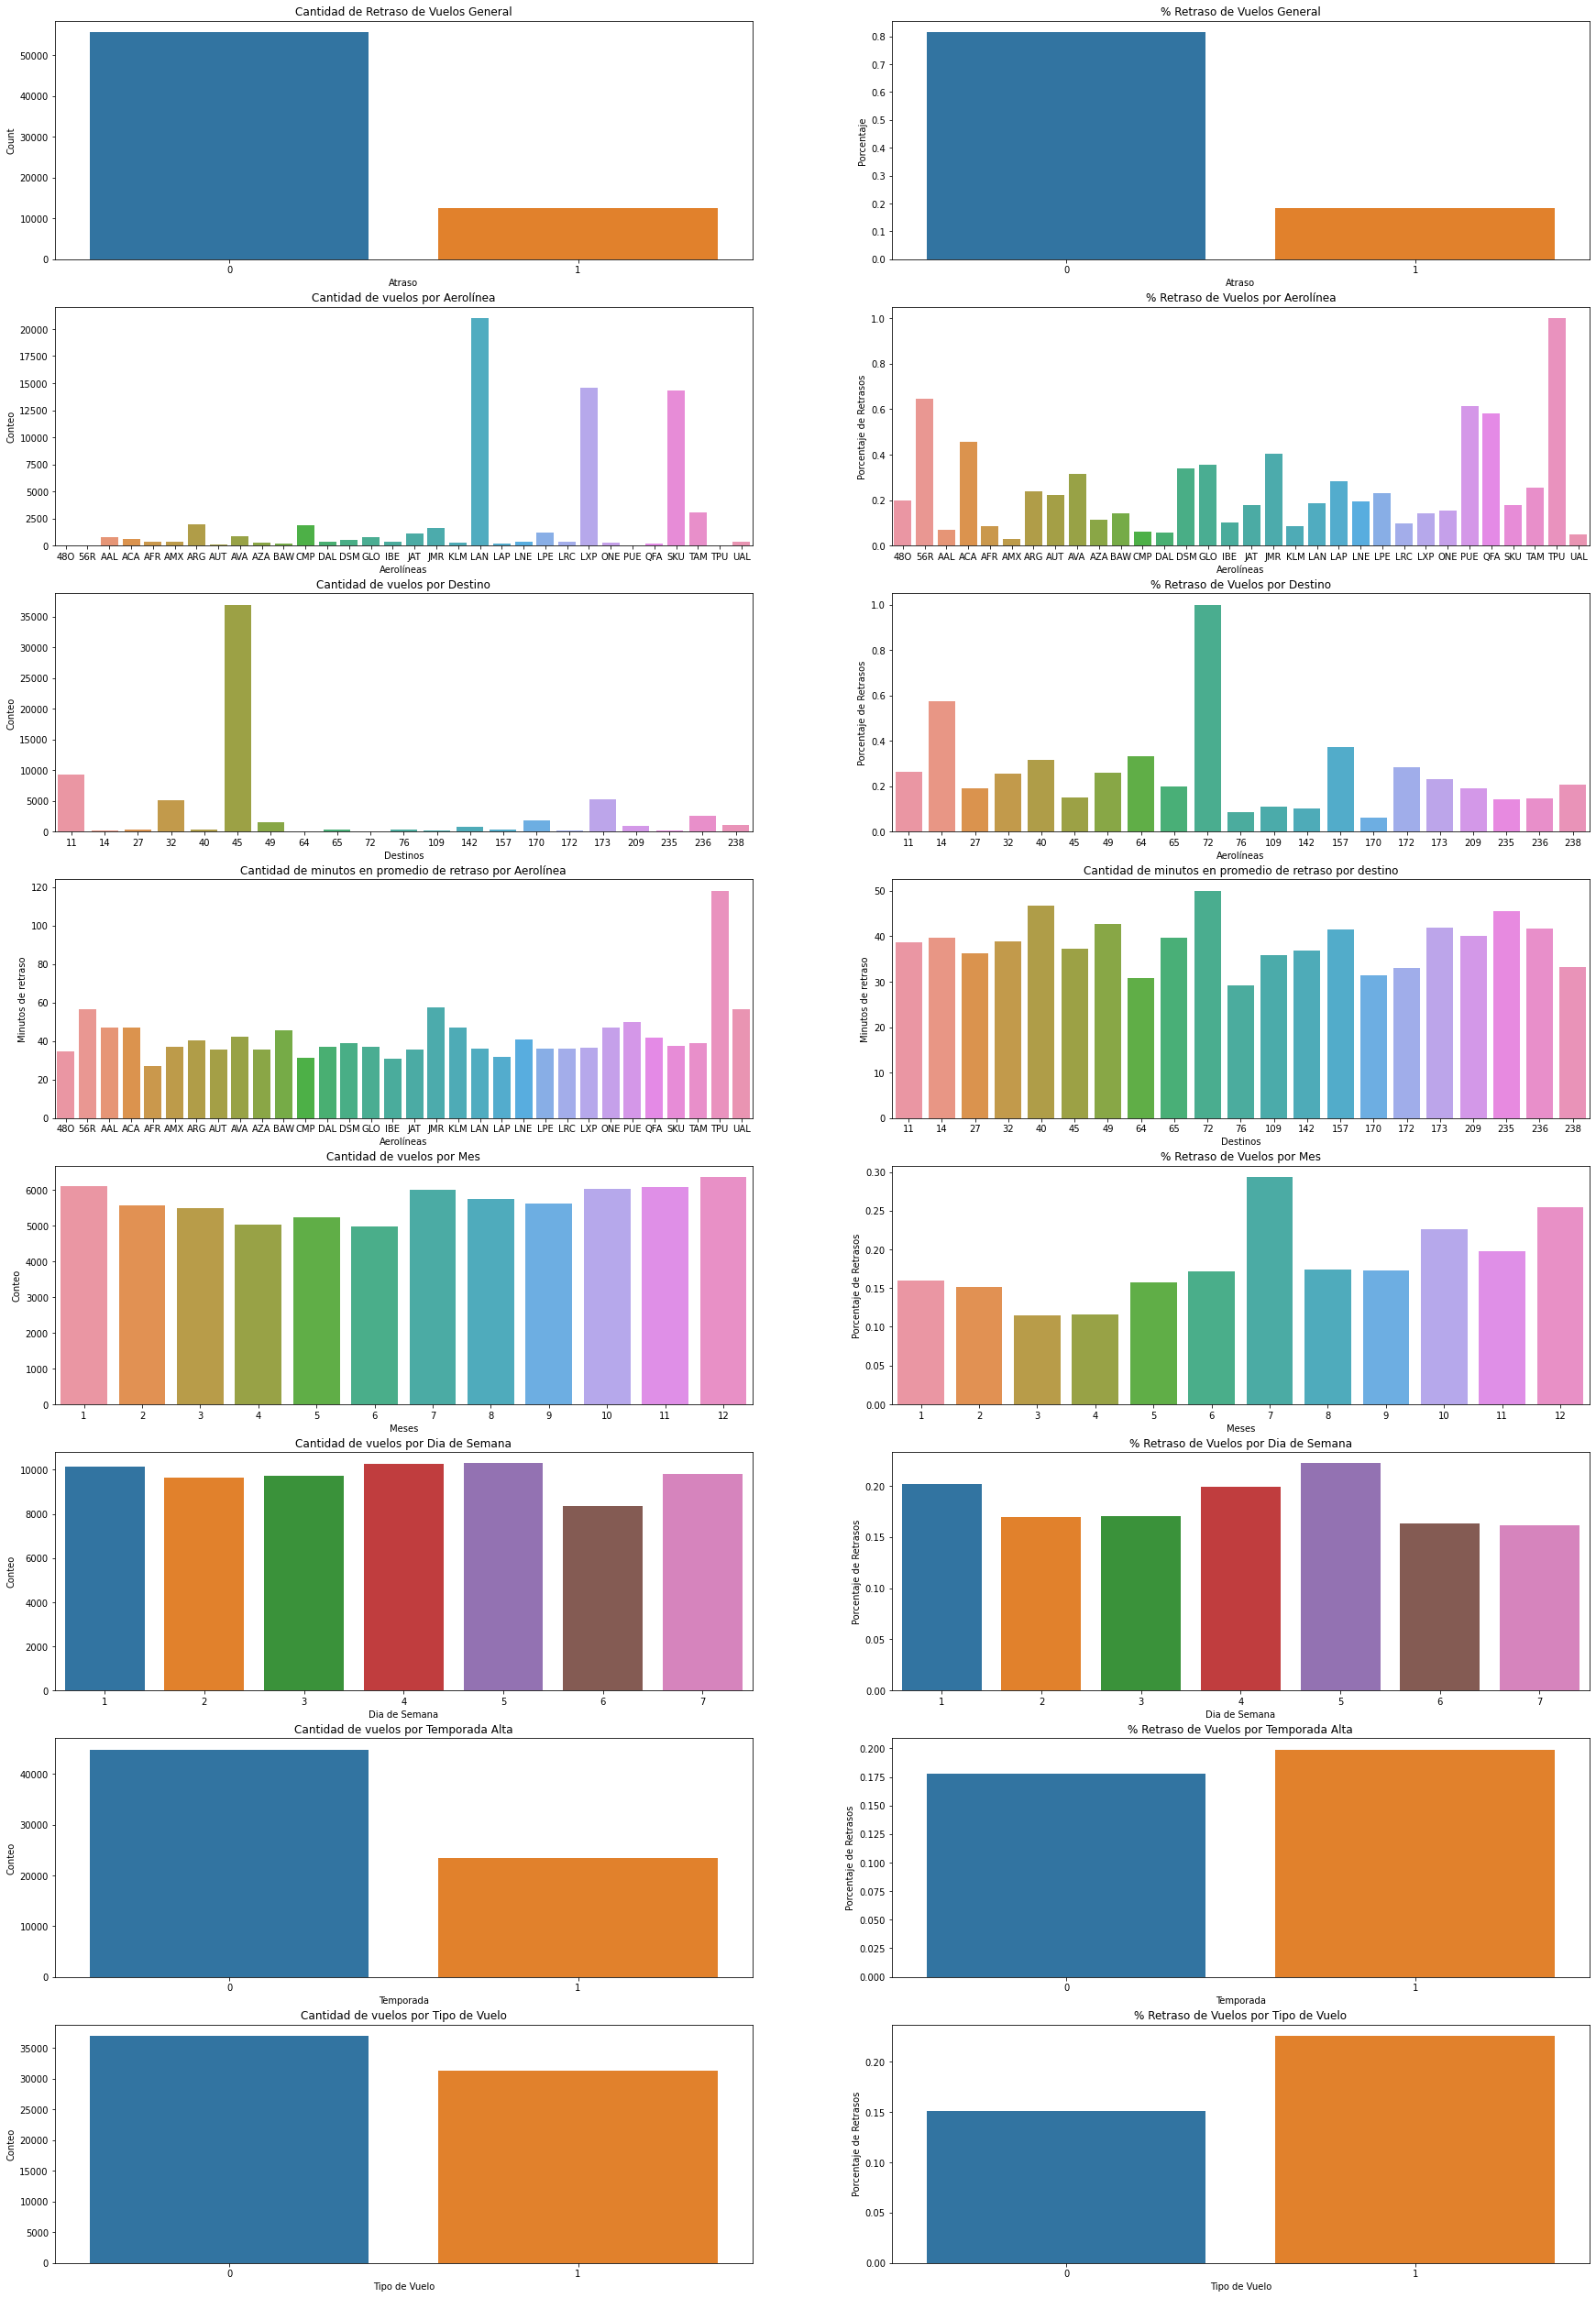

In [149]:
df_retrasos_aerolíneas = pd.DataFrame(df_t.groupby("CARRIER")["ATRASO_15"].value_counts(normalize=True)).rename(columns={"ATRASO_15":"VALUES"}).reset_index()
df_retrasos_destinos = pd.DataFrame(df_t.groupby("PAIS")["ATRASO_15"].value_counts(normalize=True)).rename(columns={"ATRASO_15":"VALUES"}).reset_index()
df_retrasos_mes = pd.DataFrame(df_t.groupby("MES")["ATRASO_15"].value_counts(normalize=True)).rename(columns={"ATRASO_15":"VALUES"}).reset_index()
df_retrasos_dia_semana = pd.DataFrame(df_t.groupby("DIA_SEMANA")["ATRASO_15"].value_counts(normalize=True)).rename(columns={"ATRASO_15":"VALUES"}).reset_index()
df_retrasos_temporada = pd.DataFrame(df_t.groupby("TEMPORADA_ALTA")["ATRASO_15"].value_counts(normalize=True)).rename(columns={"ATRASO_15":"VALUES"}).reset_index()
df_retrasos_tipo_vuelo = pd.DataFrame(df_t.groupby("TIPO_VUELO_NUMERO")["ATRASO_15"].value_counts(normalize=True)).rename(columns={"ATRASO_15":"VALUES"}).reset_index()

fig, axes = plt.subplots(8,2, figsize=(30,45))

sns.barplot(ax=axes[0, 0], data=df_t, x=df_t["ATRASO_15"].value_counts().index, y=df_t["ATRASO_15"].value_counts()).set(title="Cantidad de Retraso de Vuelos General", xlabel="Atraso", ylabel="Count")
sns.barplot(ax=axes[0, 1], data=df_t, x=df_t["ATRASO_15"].value_counts().index, y=df_t["ATRASO_15"].value_counts(normalize=True)).set(title="% Retraso de Vuelos General", xlabel="Atraso", ylabel="Porcentaje")
sns.barplot(ax=axes[1, 0], data=df_t, x=df_t.groupby("CARRIER")["ATRASO_15"].count().index, y=df_t.groupby("CARRIER")["ATRASO_15"].count()).set(title="Cantidad de vuelos por Aerolínea", xlabel="Aerolíneas", ylabel="Conteo")
sns.barplot(ax=axes[1, 1], data=df_retrasos_aerolíneas.loc[df_retrasos_aerolíneas["ATRASO_15"].isin([1])], x="CARRIER", y="VALUES").set(title="% Retraso de Vuelos por Aerolínea", xlabel="Aerolíneas", ylabel="Porcentaje de Retrasos")
sns.barplot(ax=axes[2, 0], data=df_t, x=df_t.groupby("PAIS")["ATRASO_15"].count().index, y=df_t.groupby("PAIS")["ATRASO_15"].count()).set(title="Cantidad de vuelos por Destino", xlabel="Destinos", ylabel="Conteo")
sns.barplot(ax=axes[2, 1], data=df_retrasos_destinos.loc[df_retrasos_destinos["ATRASO_15"].isin([1])], x="PAIS", y="VALUES").set(title="% Retraso de Vuelos por Destino", xlabel="Aerolíneas", ylabel="Porcentaje de Retrasos")
sns.barplot(ax=axes[3, 0], data=df_t.loc[df_t["ATRASO_15"].isin([1])] ,x=df_t.loc[df_t["ATRASO_15"].isin([1])].groupby("CARRIER")["DIF_MIN"].mean().index, y=df_t.loc[df_t["ATRASO_15"].isin([1])].groupby("CARRIER")["DIF_MIN"].mean()).set(title="Cantidad de minutos en promedio de retraso por Aerolínea", xlabel="Aerolíneas", ylabel="Minutos de retraso")
sns.barplot(ax=axes[3, 1], data=df_t.loc[df_t["ATRASO_15"].isin([1])] ,x=df_t.loc[df_t["ATRASO_15"].isin([1])].groupby("PAIS")["DIF_MIN"].mean().index, y=df_t.loc[df_t["ATRASO_15"].isin([1])].groupby("PAIS")["DIF_MIN"].mean()).set(title="Cantidad de minutos en promedio de retraso por destino", xlabel="Destinos", ylabel="Minutos de retraso")
sns.barplot(ax=axes[4, 0], data=df_t, x=df_t.groupby("MES")["ATRASO_15"].count().index, y=df_t.groupby("MES")["ATRASO_15"].count()).set(title="Cantidad de vuelos por Mes", xlabel="Meses", ylabel="Conteo")
sns.barplot(ax=axes[4, 1], data=df_retrasos_mes.loc[df_retrasos_mes["ATRASO_15"].isin([1])], x="MES", y="VALUES").set(title="% Retraso de Vuelos por Mes", xlabel="Meses", ylabel="Porcentaje de Retrasos")
sns.barplot(ax=axes[5, 0], data=df_t, x=df_t.groupby("DIA_SEMANA")["ATRASO_15"].count().index, y=df_t.groupby("DIA_SEMANA")["ATRASO_15"].count()).set(title="Cantidad de vuelos por Dia de Semana", xlabel="Dia de Semana", ylabel="Conteo")
sns.barplot(ax=axes[5, 1], data=df_retrasos_dia_semana.loc[df_retrasos_dia_semana["ATRASO_15"].isin([1])], x="DIA_SEMANA", y="VALUES").set(title="% Retraso de Vuelos por Dia de Semana", xlabel="Dia de Semana", ylabel="Porcentaje de Retrasos")
sns.barplot(ax=axes[6, 0], data=df_t, x=df_t.groupby("TEMPORADA_ALTA")["ATRASO_15"].count().index, y=df_t.groupby("TEMPORADA_ALTA")["ATRASO_15"].count()).set(title="Cantidad de vuelos por Temporada Alta", xlabel="Temporada", ylabel="Conteo")
sns.barplot(ax=axes[6, 1], data=df_retrasos_temporada.loc[df_retrasos_temporada["ATRASO_15"].isin([1])], x="TEMPORADA_ALTA", y="VALUES").set(title="% Retraso de Vuelos por Temporada Alta", xlabel="Temporada", ylabel="Porcentaje de Retrasos")
sns.barplot(ax=axes[7, 0], data=df_t, x=df_t.groupby("TIPO_VUELO_NUMERO")["ATRASO_15"].count().index, y=df_t.groupby("TIPO_VUELO_NUMERO")["ATRASO_15"].count()).set(title="Cantidad de vuelos por Tipo de Vuelo", xlabel="Tipo de Vuelo", ylabel="Conteo")
sns.barplot(ax=axes[7, 1], data=df_retrasos_tipo_vuelo.loc[df_retrasos_tipo_vuelo["ATRASO_15"].isin([1])], x="TIPO_VUELO_NUMERO", y="VALUES").set(title="% Retraso de Vuelos por Tipo de Vuelo", xlabel="Tipo de Vuelo", ylabel="Porcentaje de Retrasos")

plt.show()

### Preparación de datos

* Según la literatura, el comportamiento de los retrasos es estocástico, de ahí que se busque pronosticar probabilidad de retrasos. Para ello, es importante conocer la distribución de las variables cuantitativas pues un comportamiento disperso puede significar errores en el pronóstico. Lo ideal, será ajustarse lo máximo posible a una distribución normal para que así, el rendimiento de los modelos puedan generar confianza. Para ello, se usó el método skewness de pandas y el test de shapiro para complementar la información sobre el estado actual de los dato. Este test se ejecuta sobre los datos continuos ya que son aquellos que tienen media y desviación estándar. Luego de ejecutar la función para el propósito mencionado se usó el método de Box-Cox para intentar escalar y normalizar los datos, para posteriormente y nuevamente ver si los datos se ajustaron un poco más a una distribución normal. En la mayoría de las variables se logró una transformación óptima pues las desviaciones a la derecha e izquierda se ajustaron un poco más a lo necesario. Luego, es también importante conocer como se relacionan cada una de las variables con la variable target dado que esto nos puede ayudar a entender el resultado posterior de los modelos. Todas las variables categóricas pasaron por una prueba de Chi2 respecto de la variable objetivo, donde se busca sólo entender si éstas variables guardan algún tipo de dependencia. Este mismo ejercicio se realizó para las variables continuas usando la correlación de Spearman, éste método permite ser flexible con funciones no lineales por lo que se recomienda siempre para variables continuas con variaciones usar Spearman en lugar de Pearson. 
* Finalmente, entre las variables también es importante conocer como se correlacionan dado que la etapa de preparación de datos se trata de minimizar el ruido en el conjunto de datos para que el modelo pueda entrenar más rápido y generar mejores generalizaciones, y si dos variables guardan algún tipo de relación se hace necesario eliminar una de las variables. Para este caso las variables DISTANCIA y TIEMPO_ESTIMADO_MINUTOS, y DEP_TIME y PERIODO_DIA_NUMERO guardan información similar por lo que las variables TIEMPO_ESTIMADO_MINUTOS y PERIODO_DIA_NUMERO fueron eliminadas del conjunto de datos

In [6]:
df_shaprios_unprocessed = shapiro_normality_test(data=df_t, fields=["DIF_MIN","DEP_TIME","DISTANCIA","TIEMPO_ESTIMADO_MINUTOS"])
df_transformed = box_cox_transformation(data=df_t, fields=["DIF_MIN","DEP_TIME","DISTANCIA","TIEMPO_ESTIMADO_MINUTOS"])
df_shaprios_processed = shapiro_normality_test(data=df_transformed, fields=["DIF_MIN","DEP_TIME","DISTANCIA","TIEMPO_ESTIMADO_MINUTOS"])
df_transformed = pd.concat([df_transformed, df_t[["DIA","MES","DIA_SEMANA","ATRASO_15","TEMPORADA_ALTA","PERIODO_DIA_NUMERO","PAIS","TIPO_VUELO_NUMERO","CARRIER_NUMERO"]]], axis=1)
pd.merge(df_shaprios_unprocessed.rename(columns={"normality":"Normaility_NotProcessed", "symmetric_coef":"Coef_NotProcessed"}), df_shaprios_processed.rename(columns={"normality":"Normaility_Processed", "symmetric_coef":"Coef_Processed"}), on="field", how="inner").drop_duplicates()

c:\Python39\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,field,Normaility_NotProcessed,Coef_NotProcessed,Normaility_Processed,Coef_Processed
0,DIF_MIN,ASYMETRIC,3.860263,ASYMETRIC,-0.459878
1,DEP_TIME,ASYMETRIC,0.018763,ASYMETRIC,-0.346247
2,DISTANCIA,ASYMETRIC,2.394937,ASYMETRIC,-0.002479
3,TIEMPO_ESTIMADO_MINUTOS,ASYMETRIC,2.304027,ASYMETRIC,0.030433


In [111]:
relation_between_variables_categorical_and_continuous(df_transformed, ["DIA","MES","DIA_SEMANA","ATRASO_15","TEMPORADA_ALTA","PERIODO_DIA_NUMERO","PAIS","TIPO_VUELO_NUMERO","CARRIER_NUMERO"], ["DIF_MIN","DEP_TIME","DISTANCIA","TIEMPO_ESTIMADO_MINUTOS"], "ATRASO_15")

,fields,corrOrPvalue,DTYPE,IsRelationed
0,DIF_MIN,6.854928e-01,CONTINUOUS,True
1,DEP_TIME,5.906633e-02,CONTINUOUS,False
2,DISTANCIA,1.785063e-02,CONTINUOUS,False
3,TIEMPO_ESTIMADO_MINUTOS,1.617906e-02,CONTINUOUS,False
0,DIA,2.285657e-19,CATEGORICAL,True
1,MES,4.542249e-235,CATEGORICAL,True
2,DIA_SEMANA,3.979134e-39,CATEGORICAL,True
3,ATRASO_15,0.000000e+00,CATEGORICAL,True
4,TEMPORADA_ALTA,1.797910e-09,CATEGORICAL,True
5,PERIODO_DIA_NUMERO,4.225885e-68,CATEGORICAL,True


<AxesSubplot:>

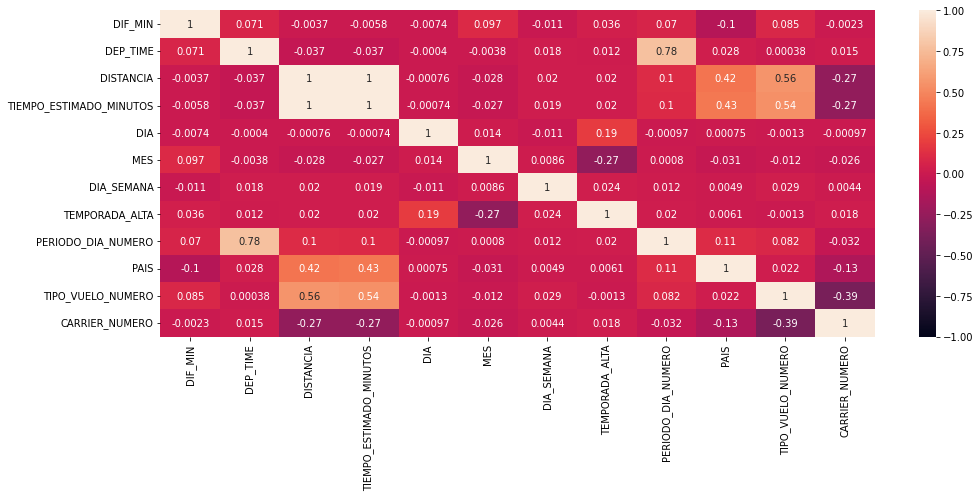

In [135]:
plt.figure(figsize=(16, 6))
sns.heatmap(df_transformed.drop(["ATRASO_15"],axis=1).corr(method="spearman"), vmin=-1, vmax=1, annot=True)

In [7]:
df_fe = df_transformed.drop(["TIEMPO_ESTIMADO_MINUTOS", "PERIODO_DIA_NUMERO"], axis=1)

### Modelado 

In [207]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, log_loss
import math
import numpy as np

In [231]:
for column in ["DIA","MES","DIA_SEMANA","ATRASO_15","TEMPORADA_ALTA","PAIS","TIPO_VUELO_NUMERO","CARRIER_NUMERO"]:
  df_fe[column] = df_fe[column].astype("category")

X = df_fe.drop(["ATRASO_15", "DIF_MIN"], axis=1)
y = df_fe["ATRASO_15"]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.85, random_state = 42)

#skf = StratifiedKFold(n_splits=10)
#for train_index, test_index in skf.split(X, y):
#  X_train_skf = X.loc[train_index,:]
#  X_test_skf = X.loc[test_index,:]
# y_train_skf = pd.DataFrame(y).loc[train_index,:]
#  y_test_skf = pd.DataFrame(y).loc[test_index,:]

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
#X_rus_skf, y_rus_skf = rus.fit_resample(X_train_skf, y_train_skf)

smotenc = SMOTENC(categorical_features=[2,3,4,5,6,7,8],random_state=42)
X_nc_smote, y_nc_smote = smotenc.fit_resample(X_train, y_train)
#X_nc_smote_skf, y_nc_smote_skf = smotenc.fit_resample(X_train_skf, y_train_skf)


#### BASE ESTIMATOR

* Se usan tres tipos de modelos de clasificación con la intención de observar que modelo base escoger; también, con el propósito de saber que tipo de modelo tiene mejor rendimiento con los datos que se tienen de momento. Los modelos Boosting, Bagging y Lineales. También se elimina una variable que puede ser fundamental para aumentar el sobreajuste del modelo, y que de todas formas no debería participar dentro del entrenamiento dado que esta es una variable de fin del proceso, así que, si se busca predecir un retraso se supone que DIF_MIN no debería existir. 

* Ya que el conjunto de datos se encuentra desbalanceado, se procede a usar dos metodos diferentes para el balanceo del mismo. El primero usando oversampling y el segundo undersampling. Ya que existen variables categóricas dentro del set de datos, para el sobremuestreo se usa un método de SMOTE con una pequeña variación que permite el sobremuestreo de este tipo de variables. 

* RandomForest parece ser un algoritmo con resultados aceptables como método base. La diferencia entre UnderSampling y OverSampling parece nos ser significativa respecto del área bajo la curva, sin embargo, una métrica que es de alto interés es recall ya que nos interesa reconocer el retraso como tal y el método UnderSampling en esta ocasión parece tener mejores resultados en esta métrica. Esto tiene un poco de sentido ya que al estar desbalanceado el sistema al agregar datos realmente no estamos agregando nueva información relevante, sin embargo, es ruido el que se está agregando y para modelos underfitted no es conveniente agregar ruido. Así que, se decide por mejorar el modelo RF usando UnderSampling. 

In [253]:
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42)
gbc_clf = GradientBoostingClassifier(random_state=42)

##### Training UnderSampling

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RF precision,LR precision,GBM precision,RF recall,LR recall,GBM recall
0,0.924152,0.860273,0.900657,0.766945,0.616649,0.662680
1,0.426234,0.261750,0.325767,0.733367,0.575742,0.690379
accuracy,0.760532,0.608836,0.667970,0.760532,0.608836,0.667970
macro avg,0.675193,0.561011,0.613212,0.750156,0.596195,0.676529
weighted avg,0.829056,0.745962,0.790860,0.760532,0.608836,0.667970


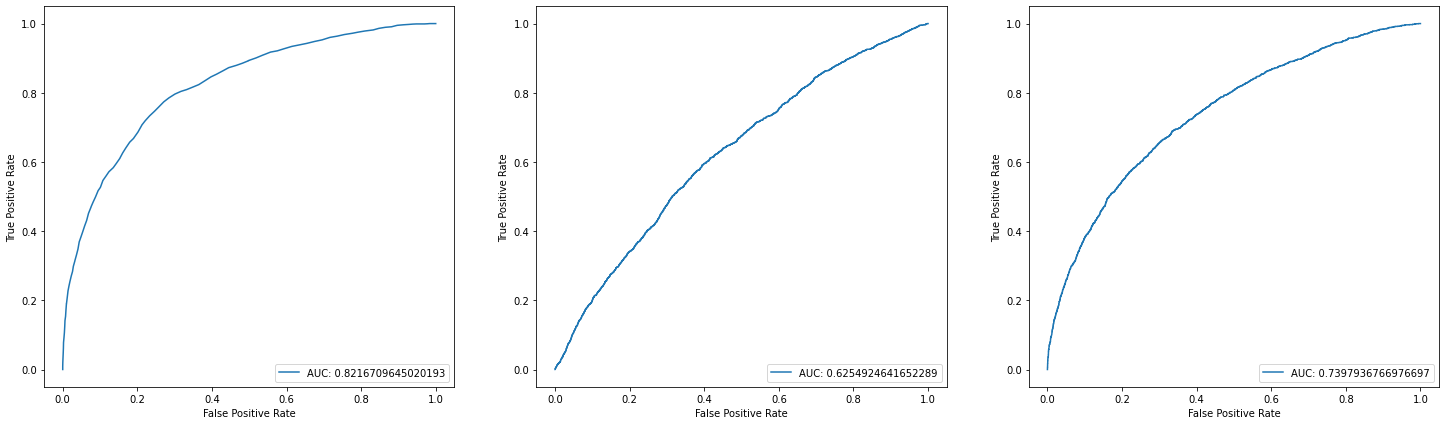

In [255]:
model_rf_clf = rf_clf.fit(X_rus, y_rus)
model_lr_clf = lr_clf.fit(X_rus, y_rus)
model_gbc_clf = gbc_clf.fit(X_rus, y_rus)

prediction_rf_clf = model_rf_clf.predict(X_test)
prediction_lr_clf = model_lr_clf.predict(X_test)
prediction_gbc_clf = model_gbc_clf.predict(X_test)

proba_prediction_rf_clf = model_rf_clf.predict_proba(X_test)
proba_prediction_lr_clf = model_lr_clf.predict_proba(X_test)
proba_prediction_gbc_clf = model_gbc_clf.predict_proba(X_test)

rf_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_rf_clf, output_dict=True)).transpose()
lr_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_lr_clf, output_dict=True)).transpose()
gbc_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_gbc_clf, output_dict=True)).transpose()

precision_metric = pd.concat(
  [
    rf_clf_modeled.rename(columns={"precision":"RF precision"})["RF precision"],
    lr_clf_modeled.rename(columns={"precision":"LR precision"})["LR precision"],
    gbc_clf_modeled.rename(columns={"precision":"GBM precision"})["GBM precision"]
  ],
  axis=1
)

recall_metric = pd.concat(
  [
    rf_clf_modeled.rename(columns={"recall":"RF recall"})["RF recall"],
    lr_clf_modeled.rename(columns={"recall":"LR recall"})["LR recall"],
    gbc_clf_modeled.rename(columns={"recall":"GBM recall"})["GBM recall"]
  ],
  axis=1
)

metrics = pd.concat([precision_metric, recall_metric], axis=1)


fig, axes = plt.subplots(1,3, figsize=(25,7))

fpr_rf_clf, tpr_rf_clf, _rf_clf = roc_curve(y_test, proba_prediction_rf_clf[:, 1])
fpr_lr_clf, tpr_lr_clf, _lr_clf = roc_curve(y_test, proba_prediction_lr_clf[:, 1])
fpr_gbc_clf, tpr_gbc_clf, _gbc_clf = roc_curve(y_test, proba_prediction_gbc_clf[:, 1])

RocCurveDisplay(fpr=fpr_rf_clf, tpr=tpr_rf_clf).plot(ax=axes[0], label=f"AUC: {roc_auc_score(y_test, proba_prediction_rf_clf[:, 1])}")
RocCurveDisplay(fpr=fpr_lr_clf, tpr=tpr_lr_clf).plot(ax=axes[1], label=f"AUC: {roc_auc_score(y_test, proba_prediction_lr_clf[:, 1])}")
RocCurveDisplay(fpr=fpr_gbc_clf, tpr=tpr_gbc_clf).plot(ax=axes[2], label=f"AUC: {roc_auc_score(y_test, proba_prediction_gbc_clf[:, 1])}")

metrics

##### Training Oversampling

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RF precision,LR precision,GBM precision,RF recall,LR recall,GBM recall
0,0.891401,0.858037,0.875851,0.943095,0.629455,0.761991
1,0.680461,0.262563,0.349835,0.513306,0.558854,0.542477
accuracy,0.861011,0.615971,0.720066,0.861011,0.615971,0.720066
macro avg,0.785931,0.560300,0.612843,0.728201,0.594154,0.652234
weighted avg,0.851114,0.744308,0.775388,0.861011,0.615971,0.720066


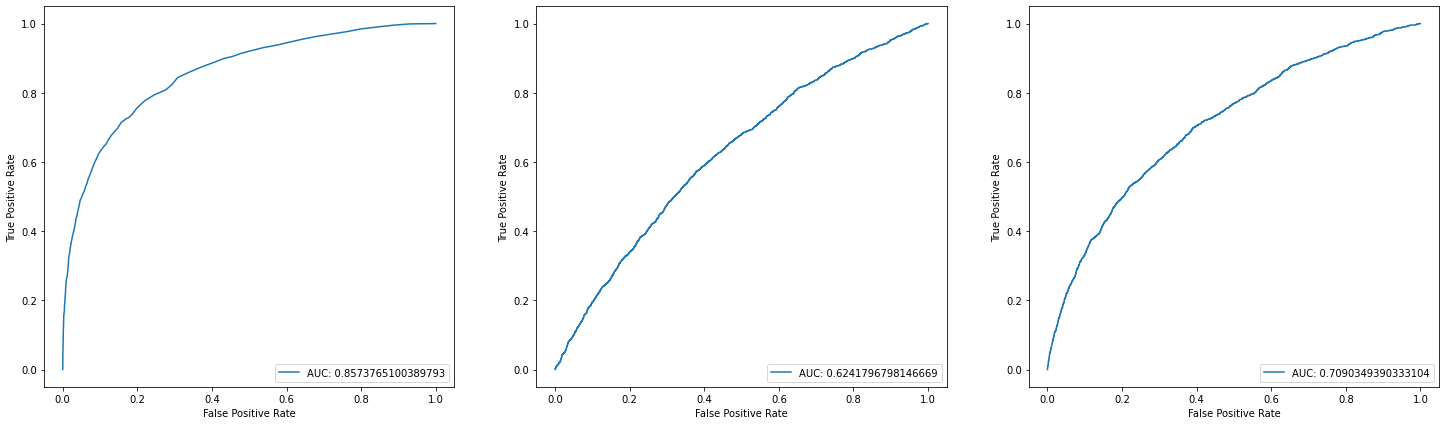

In [256]:
model_rf_clf = rf_clf.fit(X_nc_smote, y_nc_smote)
model_lr_clf = lr_clf.fit(X_nc_smote, y_nc_smote)
model_gbc_clf = gbc_clf.fit(X_nc_smote, y_nc_smote)

prediction_rf_clf = model_rf_clf.predict(X_test)
prediction_lr_clf = model_lr_clf.predict(X_test)
prediction_gbc_clf = model_gbc_clf.predict(X_test)

proba_prediction_rf_clf = model_rf_clf.predict_proba(X_test)
proba_prediction_lr_clf = model_lr_clf.predict_proba(X_test)
proba_prediction_gbc_clf = model_gbc_clf.predict_proba(X_test)

rf_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_rf_clf, output_dict=True)).transpose()
lr_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_lr_clf, output_dict=True)).transpose()
gbc_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_gbc_clf, output_dict=True)).transpose()

precision_metric = pd.concat(
  [
    rf_clf_modeled.rename(columns={"precision":"RF precision"})["RF precision"],
    lr_clf_modeled.rename(columns={"precision":"LR precision"})["LR precision"],
    gbc_clf_modeled.rename(columns={"precision":"GBM precision"})["GBM precision"]
  ],
  axis=1
)

recall_metric = pd.concat(
  [
    rf_clf_modeled.rename(columns={"recall":"RF recall"})["RF recall"],
    lr_clf_modeled.rename(columns={"recall":"LR recall"})["LR recall"],
    gbc_clf_modeled.rename(columns={"recall":"GBM recall"})["GBM recall"]
  ],
  axis=1
)

metrics = pd.concat([precision_metric, recall_metric], axis=1)


fig, axes = plt.subplots(1,3, figsize=(25,7))

fpr_rf_clf, tpr_rf_clf, _rf_clf = roc_curve(y_test, proba_prediction_rf_clf[:, 1])
fpr_lr_clf, tpr_lr_clf, _lr_clf = roc_curve(y_test, proba_prediction_lr_clf[:, 1])
fpr_gbc_clf, tpr_gbc_clf, _gbc_clf = roc_curve(y_test, proba_prediction_gbc_clf[:, 1])

RocCurveDisplay(fpr=fpr_rf_clf, tpr=tpr_rf_clf).plot(ax=axes[0], label=f"AUC: {roc_auc_score(y_test, proba_prediction_rf_clf[:, 1])}")
RocCurveDisplay(fpr=fpr_lr_clf, tpr=tpr_lr_clf).plot(ax=axes[1], label=f"AUC: {roc_auc_score(y_test, proba_prediction_lr_clf[:, 1])}")
RocCurveDisplay(fpr=fpr_gbc_clf, tpr=tpr_gbc_clf).plot(ax=axes[2], label=f"AUC: {roc_auc_score(y_test, proba_prediction_gbc_clf[:, 1])}")

metrics

### Improvement of Model

* El modelo necesita estar aún más ajustado. Existen varias formas de ajustar un modelo que no ajusta bien. Los modelos complejos le vienen bien, por ello, usamos RandomForest que a parte de que obtuvo el mejor resultado, es realmente un modelo con hiperparámetros complejos. El ajuste de los hiperparámetros también le vienen bien al modelo puesto que lo robustece aun más. Por último, la solución más adecuada sería aumentar la cantidad de features adicionales. En este trabajo se intentó buscando data exógena, pero no funcionó dado que las APIs que se encontraron no contaban con la data de las fechas que se encontraban dentro del dataset y/o limitaban la cantidad de peticiones y/o el tamaño de las respuestas. Sin embargo, acorde al SofArt, la predicción debería mejorar considerablemente al introducir datos climatológicos ya que como se menciona en uno de ellos la razón de los retrasos tipificados tanto por NAS como por las categorías relacionadas con el clima, este factor influye en más del 60% de los retrasos. Otrao de las características que se consideraron importantes y que ampliamente podrían mejorar el modelo son los datos relacionados con las llegadas ya que en el SofArt también se considera importante como motivo de retraso las variables relacionadas con los retrasos de vuelos. Esta variable no tiene un significado ambigüo dado que si se intenta pronósticar en este caso el retraso en la salida de vuelos desde el aeropuerto de Santiago, la llegada tarde de un avión que debe volver a operar saliendo desde Santiago ocasiona en cadena un retraso. El mismo caso pasaría si se busca pronósticar el retraso en la llegada, sin embargo, existen otros factores y tiempos en las diferentes etapas del vuelo que deberían ser consideradas.
* Finalmente, se genera el pronóstico de probabilidades de retraso que se piden en el ejercicio y las variables de mayor importancia.
* DEP_TIME, DIA y DISTANCIA son las tres variables más importantes, según el modelo. 

In [298]:
from logging import critical


rf_clf_gd = RandomForestClassifier(random_state=42, oob_score=True, criterion='entropy')

params = {
  'n_estimators':[100, 150, 200, 250],
  "max_depth":[70,80],
}

gs_model = GridSearchCV(rf_clf_gd, param_grid=params, scoring='recall')
gs_model.fit(X_rus, y_rus)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              oob_score=True, random_state=42),
             param_grid={'max_depth': [70, 80],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='recall')

,RF precision,RF recall
0,0.924827,0.761025
1,0.421637,0.737973
accuracy,0.756622,0.756622
macro avg,0.673232,0.749499
weighted avg,0.828724,0.756622


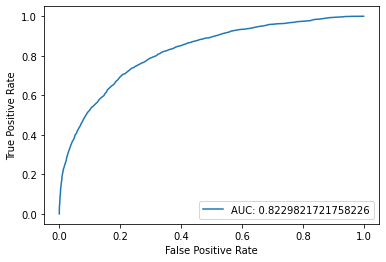

In [302]:
gs_y_pred = gs_model.predict(X_test)
gs_y_pred_proba = gs_model.predict_proba(X_test)

gs_modeled = pd.DataFrame(classification_report(y_test, gs_y_pred, output_dict=True)).transpose()


precision_metric = gs_modeled.rename(columns={"precision":"RF precision"})["RF precision"]
recall_metric = gs_modeled.rename(columns={"recall":"RF recall"})["RF recall"]

metrics = pd.concat([precision_metric, recall_metric], axis=1)

fpr_gs, tpr_gs, _gs = roc_curve(y_test, gs_y_pred_proba[:, 1])

RocCurveDisplay(fpr=fpr_gs, tpr=tpr_gs).plot(label=f"AUC: {roc_auc_score(y_test, gs_y_pred_proba[:, 1])}")

metrics

In [304]:
result = pd.DataFrame(gs_y_pred_proba, index=y_test.index).rename(columns={0:'Probabilidad de Cumplimiento', 1:'Probabilidad de Atraso'})
result["Probabilidad de Cumplimiento"] = result["Probabilidad de Cumplimiento"].apply(lambda x: '%.17f' % x).values.tolist()
result["Probabilidad de Atraso"] = result["Probabilidad de Atraso"].apply(lambda x: '%.17f' % x).values.tolist()

y_prediction = pd.concat([y_test, result], axis=1)
y_prediction["pred"] = gs_y_pred

y_prediction


,ATRASO_15,Probabilidad de Cumplimiento,Probabilidad de Atraso,pred
27320,0,0.60399999999999998,0.39600000000000002,0
57460,0,0.90400000000000003,0.09600000000000000,0
54916,0,0.76400000000000001,0.23599999999999999,0
34252,1,0.41199999999999998,0.58799999999999997,1
13524,0,0.50000000000000000,0.50000000000000000,0
...,...,...,...,...
66701,0,0.32000000000000001,0.68000000000000005,1
29214,0,0.26800000000000002,0.73199999999999998,1
24139,0,0.57999999999999996,0.41999999999999998,0
32341,0,0.43200000000000000,0.56799999999999995,1


In [314]:
df_feature_importance = pd.DataFrame({
  "features":X_test.columns.tolist(),
  "importance":gs_model.best_estimator_.feature_importances_
})
df_feature_importance.sort_values(by="importance", ascending=False)

,features,importance
0,DEP_TIME,0.364831
2,DIA,0.180244
1,DISTANCIA,0.125412
3,MES,0.099899
4,DIA_SEMANA,0.094759
8,CARRIER_NUMERO,0.079930
6,PAIS,0.029912
5,TEMPORADA_ALTA,0.016788
7,TIPO_VUELO_NUMERO,0.008225


### Costos

* No se encontrón un documento del aeropuerto de Santiago que hablara sobre el costo que representa el retraso para aerolíneas y usuarios. Otros papers más actualizados tasan a 70 USD el valor de retraso por minuto.
* Sin lugar a dudas, las aerolíneas que más minutos acumulen más dinero pierden respecto del retraso (Valor del retraso tomado como la media de los documentos referenciados)
* Es también válido aclarar que, ninguno de los documentos leídos e investigados se refierena si los minutos de retraso en cumplimiento, es decir, antes de los 15 minutos son también tenidos en cuenta como pérdidos. Esto, dado que algunas referencias documentan que cada aerolínea se siente cómoda con una tasa de inclumplimiento dentro del 30% al 40%

[Text(0.5, 1.0, 'Valor en USD e7 de pérdidas por retrasos de vuelo por Aerolínea'),
 Text(0.5, 0, 'Aerolíneas'),
 Text(0, 0.5, 'USD e7')]

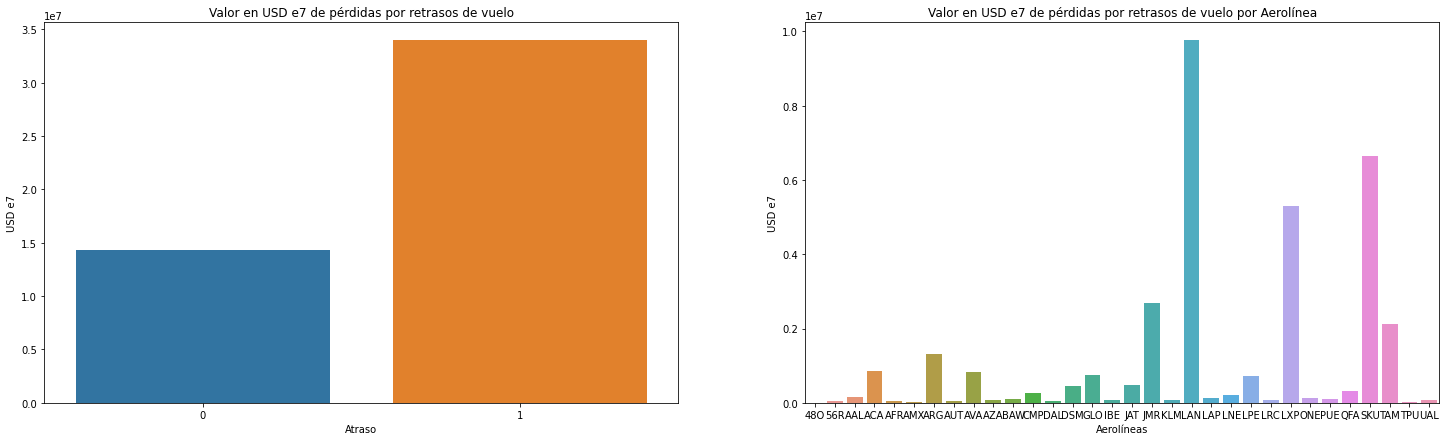

In [327]:
fig, axes = plt.subplots(1,2, figsize=(25,7))
sns.barplot(ax=axes[0], data=df_t, x=df_t.groupby(["ATRASO_15"])["DIF_MIN"].sum().index, y=df_t.groupby(["ATRASO_15"])["DIF_MIN"].sum()*70).set(title="Valor en USD e7 de pérdidas por retrasos de vuelo", xlabel="Atraso", ylabel="USD e7")
sns.barplot(ax=axes[1], data=df_t, x=df_t.loc[df_t["ATRASO_15"].isin([1])].groupby(["CARRIER"])["DIF_MIN"].sum().index, y=df_t.loc[df_t["ATRASO_15"].isin([1])].groupby(["CARRIER"])["DIF_MIN"].sum()*70).set(title="Valor en USD e7 de pérdidas por retrasos de vuelo por Aerolínea", xlabel="Aerolíneas", ylabel="USD e7")